### Import


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Read Dataset

In [10]:
df = pd.read_csv("pheme_spread_risk_dataset.csv")
print(df.shape)
print(df["spread_risk"].value_counts())

(5802, 9)
spread_risk
0    3918
1    1884
Name: count, dtype: int64


### Early Speed vs Risk 

<Figure size 640x480 with 0 Axes>

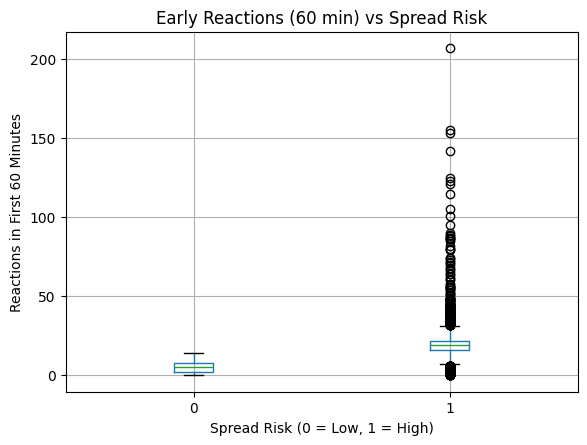

In [4]:
plt.figure()
df.boxplot(column="reactions_60min", by="spread_risk")
plt.title("Early Reactions (60 min) vs Spread Risk")
plt.suptitle("")
plt.xlabel("Spread Risk (0 = Low, 1 = High)")
plt.ylabel("Reactions in First 60 Minutes")
plt.show()


### Cascade Depth vs Risk

<Figure size 640x480 with 0 Axes>

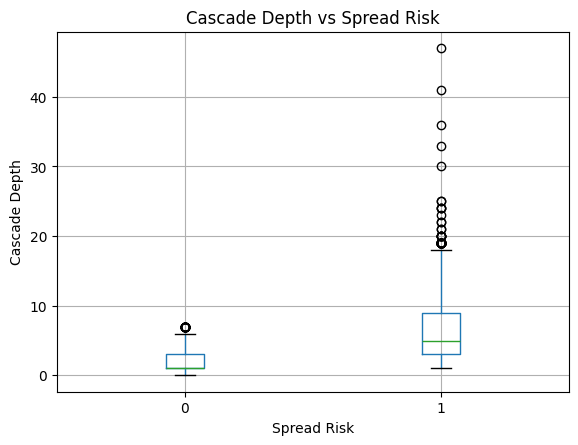

In [5]:
plt.figure()
df.boxplot(column="cascade_depth", by="spread_risk")
plt.title("Cascade Depth vs Spread Risk")
plt.suptitle("")
plt.xlabel("Spread Risk")
plt.ylabel("Cascade Depth")
plt.show()


### Depth vs Width

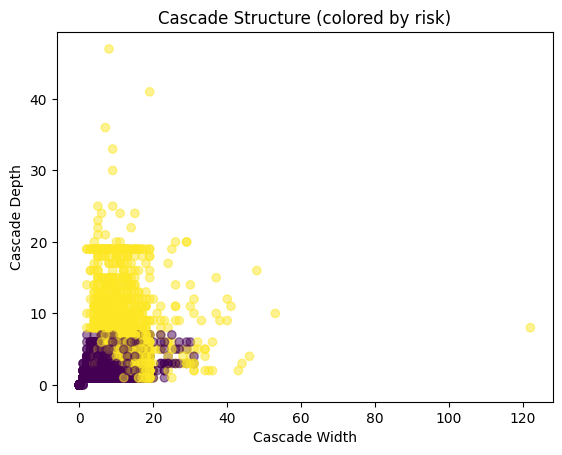

In [6]:
plt.figure()
plt.scatter(
    df["cascade_width"],
    df["cascade_depth"],
    c=df["spread_risk"],
    alpha=0.5
)
plt.xlabel("Cascade Width")
plt.ylabel("Cascade Depth")
plt.title("Cascade Structure (colored by risk)")
plt.show()


### Early Speed Distribution

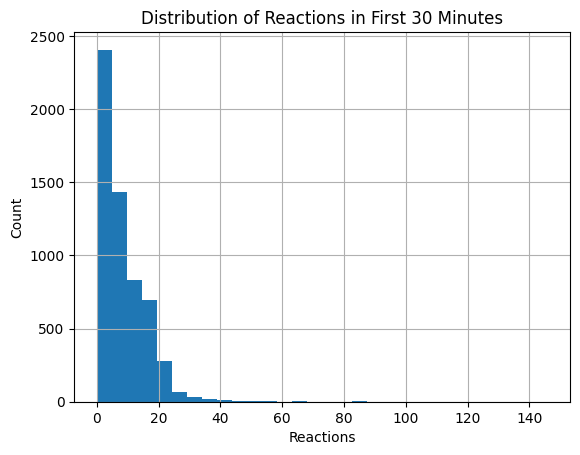

In [7]:
plt.figure()
df["reactions_30min"].hist(bins=30)
plt.title("Distribution of Reactions in First 30 Minutes")
plt.xlabel("Reactions")
plt.ylabel("Count")
plt.show()


### Rumour vs Non-Rumour

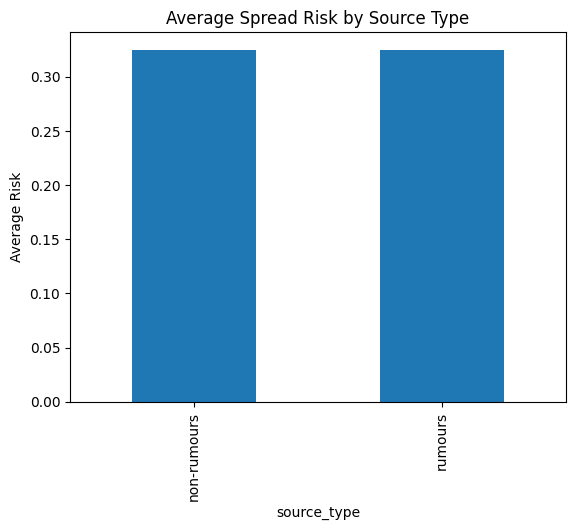

In [8]:
df.groupby("source_type")["spread_risk"].mean().plot(kind="bar")
plt.title("Average Spread Risk by Source Type")
plt.ylabel("Average Risk")
plt.show()

In [17]:
from sklearn.preprocessing import StandardScaler

# Load merged dataset
df = pd.read_csv(r"F:\PHEME\pheme_final_dataset.csv")

# Features to scale
feature_cols = [
    "total_reactions",
    "reactions_30min",
    "reactions_60min",
    "cascade_depth",
    "cascade_width",
    "tweets_per_day",
    "avg_gap_minutes",
    "burstiness",
    "topic_entropy"
]

# Target
target_col = "spread_risk"

# Create X and y
X = df[feature_cols]
y = df[target_col]

# Initialize scaler
scaler = StandardScaler()

# Fit + transform features
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame (important for sanity)
df_scaled = pd.DataFrame(
    X_scaled,
    columns=feature_cols
)

# Add target back
df_scaled[target_col] = y.values

print("Scaled dataset shape:", df_scaled.shape)
print(df_scaled.head())


Scaled dataset shape: (5802, 10)
   total_reactions  reactions_30min  reactions_60min  cascade_depth  \
0        -0.387647        -0.745018        -0.576138       0.401669   
1        -0.487183        -0.383526        -0.397142      -0.113640   
2        -0.586720        -0.624521        -0.576138      -0.628948   
3        -0.188574        -0.022035         0.139846       1.689940   
4        -0.039269         0.700948         0.318843       0.401669   

   cascade_width  tweets_per_day  avg_gap_minutes  burstiness  topic_entropy  \
0      -0.667384       -0.146647        -0.023842   -0.170220      -0.218124   
1      -0.667384        2.169249         0.017775    1.878604       4.726546   
2      -0.667384       -0.146647        -0.023842   -0.170220      -0.218124   
3      -0.991495       -0.146647        -0.023842   -0.170220      -0.218124   
4       0.142895       -0.146647        -0.023842   -0.170220      -0.218124   

   spread_risk  
0            0  
1            0  
2       

### Train/Test Split


In [18]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = df_scaled.drop(columns=["spread_risk"])
y = df_scaled["spread_risk"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (4351, 9)
Test size: (1451, 9)


### Train Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",  # IMPORTANT
    random_state=42
)

model.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


### Evaluate Properly

In [21]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score
)

# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.9565816678152997
ROC-AUC: 0.9919298929762987

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       980
           1       0.92      0.95      0.93       471

    accuracy                           0.96      1451
   macro avg       0.95      0.96      0.95      1451
weighted avg       0.96      0.96      0.96      1451



### Feature Importance

In [23]:
import pandas as pd

coef_df = pd.DataFrame({
    "feature": X.columns,
    "coefficient": model.coef_[0]
}).sort_values(by="coefficient", ascending=False)

print(coef_df)


           feature  coefficient
2  reactions_60min     5.453128
3    cascade_depth     3.601634
1  reactions_30min     1.366901
0  total_reactions     0.973416
4    cascade_width     0.501544
6  avg_gap_minutes     0.034283
5   tweets_per_day     0.014387
8    topic_entropy    -0.003539
7       burstiness    -0.036586


### Confusion Matrix

In [24]:
from sklearn.metrics import confusion_matrix
import pandas as pd

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm,
    index=["Actual Low Risk", "Actual High Risk"],
    columns=["Predicted Low Risk", "Predicted High Risk"]
)

print(cm_df)


                  Predicted Low Risk  Predicted High Risk
Actual Low Risk                  939                   41
Actual High Risk                  22                  449


### Test

In [25]:
# Shuffle labels (DESTROY signal)
import numpy as np
y_shuffled = np.random.permutation(y)

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X, y_shuffled, test_size=0.25
)

model.fit(X_train_s, y_train_s)
y_prob_s = model.predict_proba(X_test_s)[:, 1]

from sklearn.metrics import roc_auc_score
print("ROC-AUC with shuffled labels:", roc_auc_score(y_test_s, y_prob_s))


ROC-AUC with shuffled labels: 0.4702909519365978


### Build Pipeline

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import joblib


In [27]:
# Features and target
feature_cols = [
    "total_reactions",
    "reactions_30min",
    "reactions_60min",
    "cascade_depth",
    "cascade_width",
    "tweets_per_day",
    "avg_gap_minutes",
    "burstiness",
    "topic_entropy"
]

X = df[feature_cols]
y = df["spread_risk"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=42
)

# Pipeline = scaler + model
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=42
    ))
])

# Train
pipeline.fit(X_train, y_train)

# Evaluate
y_prob = pipeline.predict_proba(X_test)[:, 1]
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


ROC-AUC: 0.9919450582780883


### Save model

In [28]:
joblib.dump(pipeline, "spread_risk_model.joblib")
print("Model saved.")


Model saved.
